In [1]:
import os
print(os.getcwd())
import sys
sys.path.append('/local/scratch/kchan76/sparse-coarse-operator/')
from libs.pde import *
from libs.rotated_laplacian import RotatedLaplacian
from libs.models import BasicNet, MultiHeadedAttention
from libs.utils import *
import torch

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print('device:', device)

/local/scratch/kchan76/sparse-coarse-operator/tests/laplacian/fixed-xi


/local/scratch/kchan76/sparse-stencil-learning/src/pyamg2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device: cuda:1


In [36]:
# Initialization
list_eps = [1/300]
low_pi = 2
high_pi = 3
theta_low = np.pi/12*low_pi
theta_high = np.pi/12*high_pi
# 10 points: xi = 300, 6-7
npts = 5
list_theta = np.linspace(theta_low, theta_high, npts)

In [37]:
train_grid_size = 31
'''
k for 2-3    3-4    6-7
100   10,10  15,15  30,15                  
200   19,15  19,15  20,15                
300   15,15  15,15  30,15     
400   20,15  20,15  20,15                 
'''
k2 = 15
k3 = 15
same_vecs = False
PDE = RotatedLaplacian(train_grid_size,[k2,k3],list_eps, list_theta,'fixed xi',same_vecs=same_vecs)

In [38]:
# Load Model
MODEL_DIR = f"./models/laplacian/fixed-xi/xi-{int(1/list_eps[0])}/theta-{low_pi}pi\\12-{high_pi}pi\\12/"
model_prob_l2=torch.load(MODEL_DIR+"level2_prob.pt")
model_value_l2=torch.load(MODEL_DIR+"level2_value.pt")
model_prob_l3=torch.load(MODEL_DIR+"level3_prob.pt")
model_value_l3 = torch.load(MODEL_DIR+"level3_value.pt")

In [39]:
# xi100 = {2:[[],[]],3:[[],[]],6:[[],[]]}
# xi200 = {2:[[],[]],3:[[],[]],6:[[],[]]}
# xi300 = {2:[[],[]],3:[[],[]],6:[[],[]]}
# xi400 = {2:[[],[]],3:[[],[]],6:[[],[]]}

In [40]:
# generate additional data points
'''
seed for  2-3.   3-4.   6-7 (3-level)
100.      65(20) 14.    49
200       13     15     30(doesn't work well here, use xi200.ipynb)
300       4      2      17
400       27     1(20)  10
'''
test_seed = 4
set_global_seed(test_seed)
print('test seed:', test_seed)
sizes = [63,95,127,191,255,383,511]
num_test = 10
models = {}
models['level2'] = model_prob_l2, model_value_l2
models['level3'] = model_prob_l3, model_value_l3
max_levels = 3
epsilon = tuple(list_eps)
theta = (theta_low, theta_high)
random_test = True
'''
softmax false for : xi-300, 6-7; xi-200, 2-3; xi-200, 3-4
'''
softmax_topk = True

for test_grid_size in sizes:
    print('size:',test_grid_size)
    set_global_seed(test_seed)
    num_iter_standard, num_iter_learning, thetaList, _, _ = PDE.test_model(num_test,
                                                            models,
                                                            test_grid_size,
                                                            max_levels,
                                                            epsilon,
                                                            theta,
                                                            device,
                                                            random_test=random_test,
                                                            single_model= False,
                                                            softmax_on = softmax_topk,
                                                            verbose = True)
    xi300[low_pi][0].append(np.mean(num_iter_standard))
    xi300[low_pi][1].append(np.mean(num_iter_learning))

test seed: 4
size: 63
standard stencil iter:    169.1   standard stencil time:   0.2810445070266724
learned stencil iter:    148.3   learned stencil time:   0.5208430051803589
size: 95
standard stencil iter:    202.6   standard stencil time:   0.547452187538147
learned stencil iter:    181.5   learned stencil time:   0.9117596626281739
size: 127
standard stencil iter:    221.1   standard stencil time:   1.7861022710800172
learned stencil iter:    200.9   learned stencil time:   2.431207299232483
size: 191
standard stencil iter:    230.9   standard stencil time:   3.424527668952942
learned stencil iter:    216.8   learned stencil time:   4.690406131744385
size: 255
standard stencil iter:    238.5   standard stencil time:   6.091833901405335
learned stencil iter:    228.3   learned stencil time:   8.367388224601745
size: 383
standard stencil iter:    246.2   standard stencil time:   13.706003904342651
learned stencil iter:    241.7   learned stencil time:   19.89992229938507
size: 511
st

In [74]:
xi100

{2: [[79.15, 85.8, 88.95, 91.1, 91.85, 93.55, 93.9],
  [67.7, 75.15, 79.75, 83.8, 85.8, 87.4, 88.55]],
 3: [[88.0, 93.0, 97.3, 99.0, 101.1, 102.0, 102.8],
  [78.3, 84.1, 89.3, 92.8, 95.3, 97.1, 101.9]],
 6: [[119.4, 124.0, 124.9, 125.6, 126.6, 126.8, 126.9],
  [116.6, 121.4, 123.2, 124.1, 126.1, 128.3, 130.2]]}

In [50]:
xi200

{2: [[146.2, 164.6, 174.6, 182.9, 186.4, 190.7, 191.7],
  [126.6, 145.0, 155.1, 164.2, 169.3, 174.1, 175.7]],
 3: [[150.8, 169.1, 177.5, 188.8, 192.4, 195.8, 196.6],
  [129.6, 146.8, 157.5, 169.3, 172.7, 177.7, 179.3]],
 6: [[182.1, 192.4, 198.1, 200.5, 202.4, 202.4, 203.1],
  [178.2, 188.7, 194.8, 199.8, 203.0, 205.3, 213.4]]}

In [213]:
xi400

{2: [[211.2, 265.0, 285.6, 308.4, 323.6, 333.9],
  [184.0, 232.4, 258.2, 283.7, 303.8, 317.3]],
 3: [[212.05, 263.4, 289.1, 311.85, 322.25, 332.05, 336.7],
  [185.0, 231.4, 260.8, 289.3, 305.05, 323.7, 340.15]],
 6: [[344.2, 393.9, 414.2, 429.7, 434.3, 437.3, 438.2],
  [338.9, 389.0, 410.9, 431.5, 440.1, 446.8, 452.6]]}

In [174]:
xi300

{2: [[169.1, 202.6, 221.1, 230.9, 238.5, 246.2],
  [148.2, 181.7, 200.9, 216.9, 228.6, 242.1]],
 3: [[183.7, 220.1, 238.5, 256.9, 262.7, 267.0],
  [145.3, 173.4, 189.4, 209.1, 218.2, 230.0]],
 6: [[281.7, 314.4, 326.8, 337.5, 340.8, 342.2],
  [275.3, 306.7, 317.1, 330.3, 340.4, 348.1]]}

True

In [34]:
# list_eps = [1/100]
# low_pi = 2
# high_pi = 3

import os
MODEL_DIR = f"./../../../figs/laplacian/fixed-xi/xi-{int(1/list_eps[0])}/"
if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)

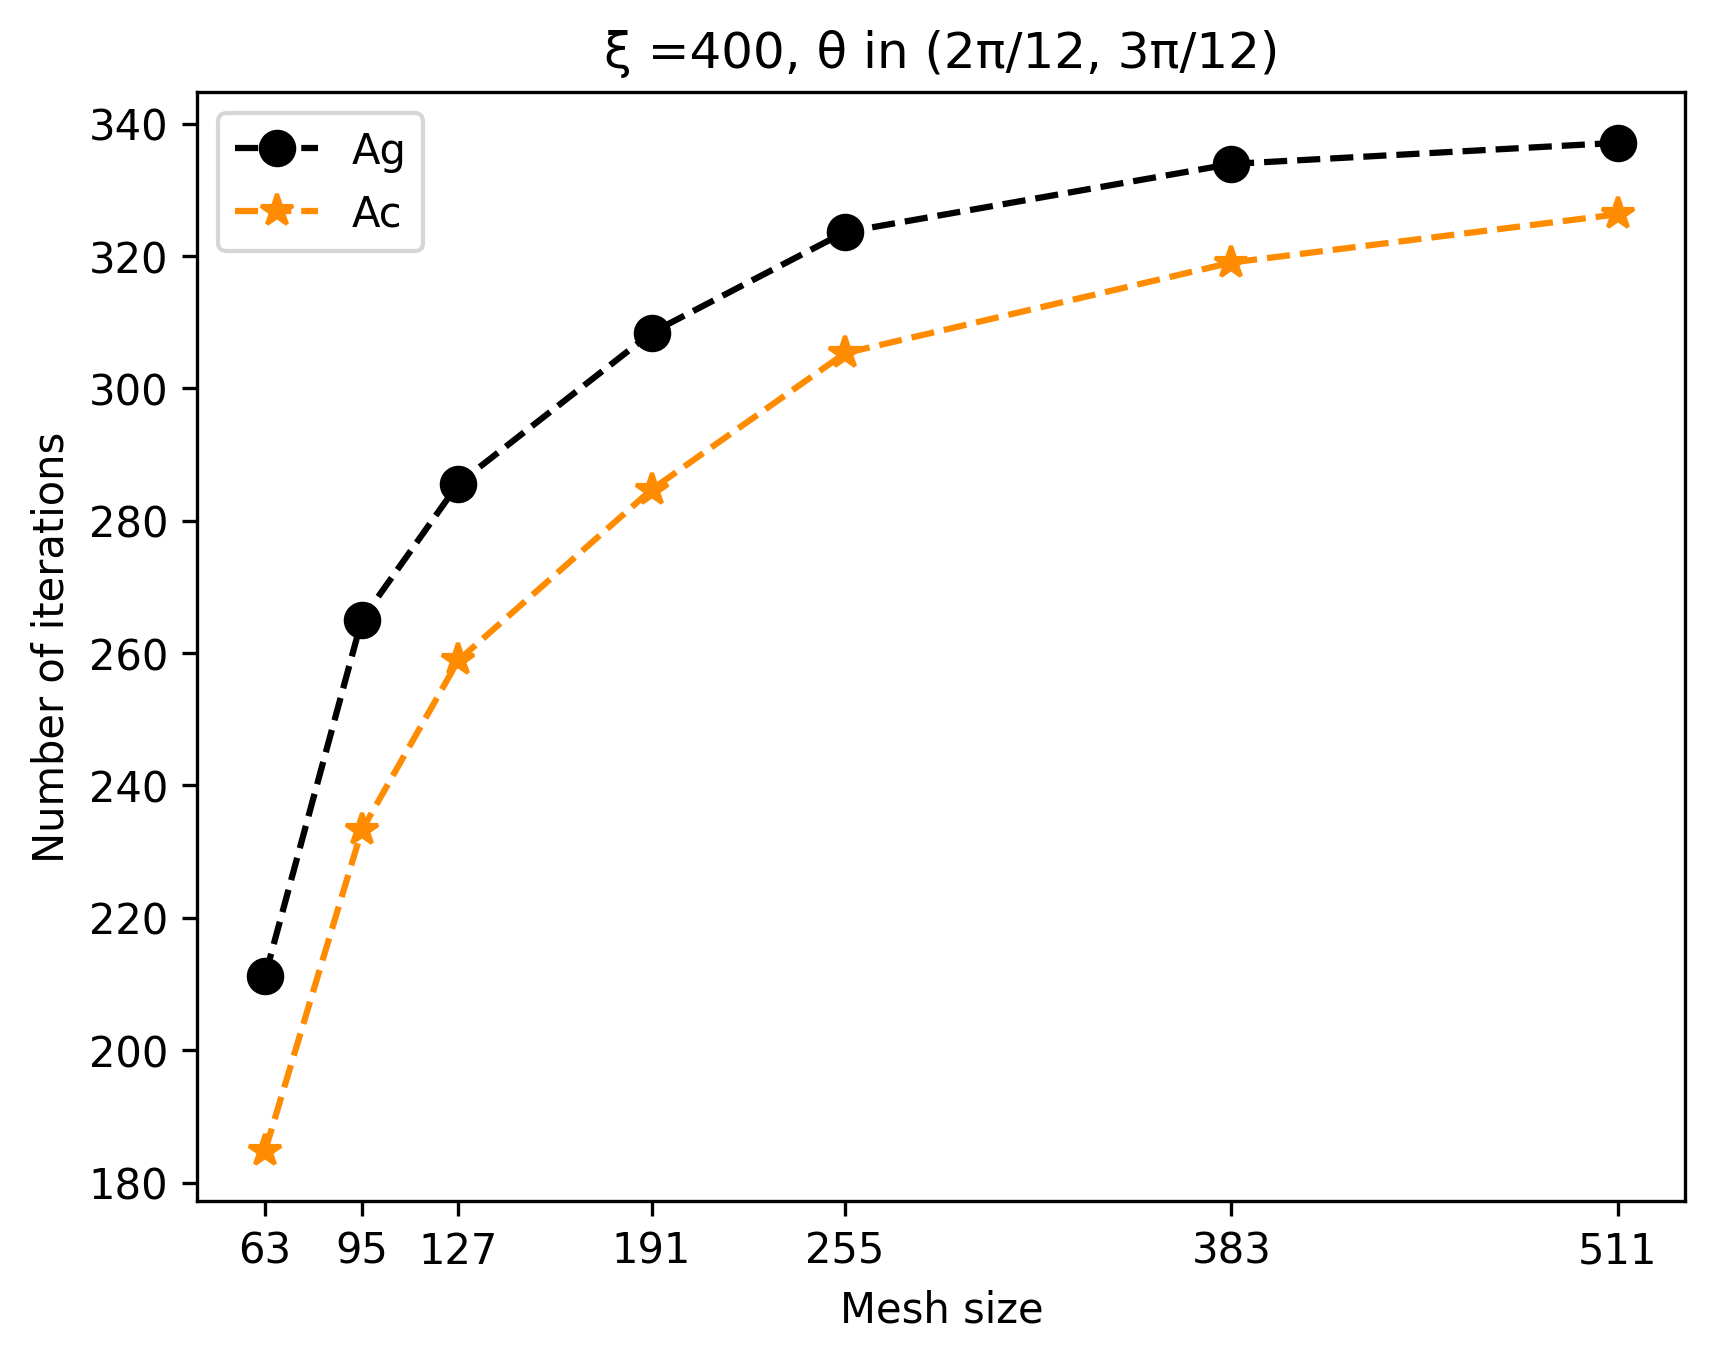

In [35]:
import matplotlib.pyplot as plt
import numpy as np

sizes = [63,95,127,191,255,383,511]
Ag = xi300[low_pi][0]
Ac = xi300[low_pi][1]
title_name = f"ξ ={int(1/list_eps[0])}, θ in ({low_pi}π/12, {high_pi}π/12)"

fig = plt.figure(dpi=300)
plt.plot(sizes,Ag, '--o',color='black', markersize=8, label='Ag',lw=1.5)
plt.plot(sizes,Ac, '--*',color='darkorange', markersize=8, label='Ac',lw=1.5)
plt.legend()
plt.xticks(sizes)
plt.xlabel("Mesh size")
plt.ylabel("Number of iterations")
plt.title(title_name)
# file_name = MODEL_DIR + f"theta-{low_pi}pi\\12-{high_pi}pi\\12.png"
# plt.savefig(file_name)
plt.show()